In [1]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
#set workdir
os.chdir("/content/gdrive/My Drive/Projects/MSc-Project-River-Segmentation/MSc-Project/Code")

dataset_dir = os.path.normpath("/content/gdrive/My Drive/Data/sentinel-river-segmentation-dataset/sentinel-river-segmentation-dataset")


In [4]:
! ls


config.cfg     Evaluation.ipynb  __pycache__	 Testing.ipynb
dataloader.py  models		 state_dict.pth  Training.ipynb


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from dataloader import Dataset
from torchinfo import summary
import time
import copy

from tqdm import tqdm

from models.unet import UNet
from models.simple import Simple

from dataloader import Dataset

In [6]:
PARAMS = {
    "input_size": 416,
    "output_size": 416,
    "model": "vgg_unet",
    "learning_rate": 0.001,
    "n_classes": 2,

    
}

In [7]:
x_train_dir = os.path.join(dataset_dir,"x_train")
y_train_dir = os.path.join(dataset_dir,"y_train")
x_test_dir = os.path.join(dataset_dir,"x_test")
y_test_dir = os.path.join(dataset_dir,"y_test")

In [8]:
train_set = Dataset(x_train_dir, y_train_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"])
test_set = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"])

batch_size = 8
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [13]:
# load weights
from models.vgg_unet import VggUnet
model = VggUnet()
model.load_state_dict(torch.load("state_dict.pth", map_location="cpu"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [14]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def reverse_transform(inp):
    print(inp.shape)
    inp = inv_normalize(inp)
    inp = inp.numpy()
    inp = np.swapaxes(inp, 1, 3)
    inp = np.swapaxes(inp, 1, 2)
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

def labels2mask(labels):
    return labels[:,1,:,:]

In [19]:
import matplotlib.pyplot as plt
def plot_side_by_side(rgb,ground_truth,predict):
    assert rgb.shape[0] == ground_truth.shape[0] == predict.shape[0]
    batch_size = rgb.shape[0]
    fig, axs = plt.subplots(batch_size, 3, figsize=(20,20))
    for i in range(batch_size):
        #print(ground_truth[i])
        #print(predict[i])
        axs[i, 0].imshow(rgb[i])
        axs[i, 1].imshow(ground_truth[i])
        axs[i, 2].imshow(predict[i])

torch.Size([2, 3, 416, 416])


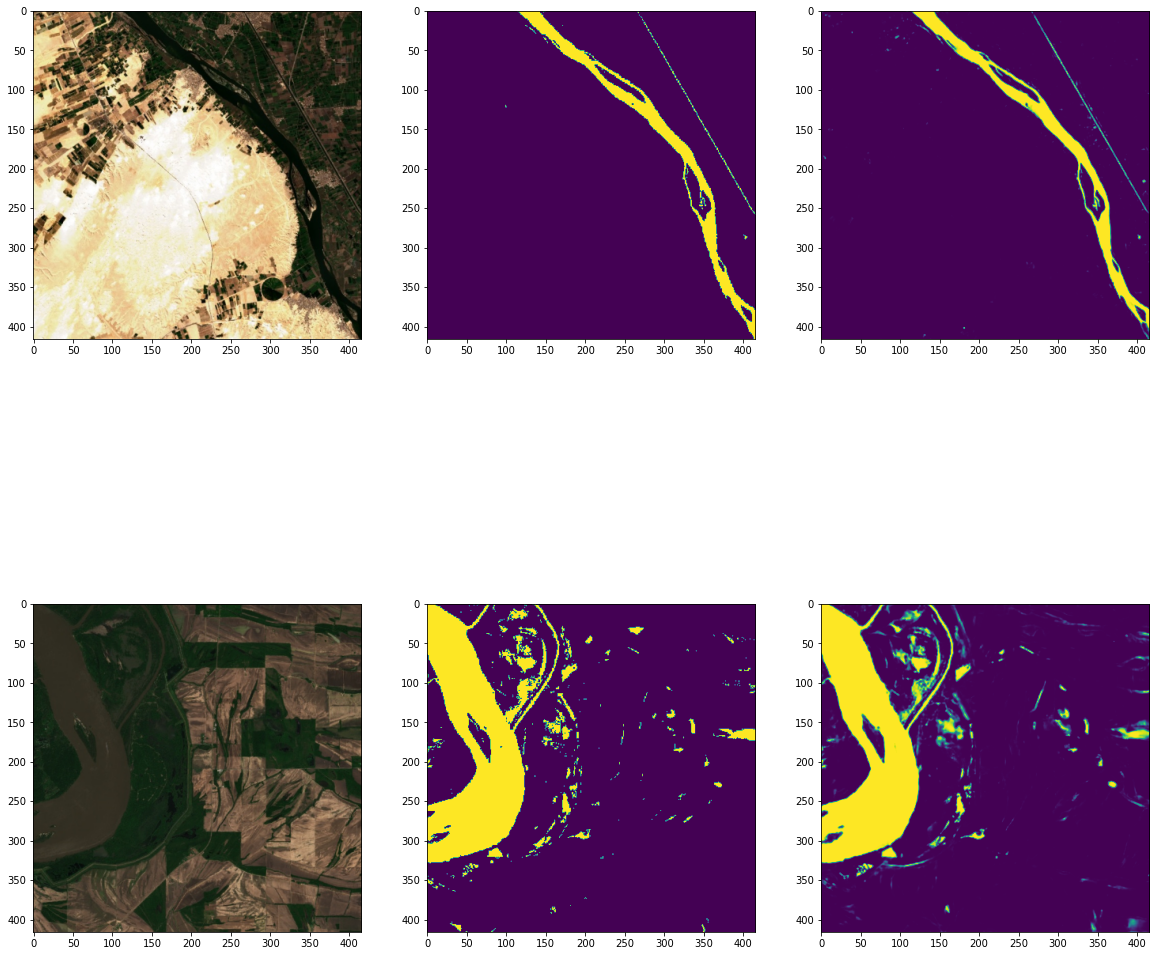

In [24]:
# visualize example segmentation

import math
model.eval()   # Set model to evaluate mode

test_dataset = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"])
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
labels = labels.data.cpu().numpy()

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
inputs = inputs.data.cpu()

#print(inputs.shape)
#print(labels)
#print(torch.sigmoid(torch.from_numpy(pred)).round())

# dataloader return normalized input image, so we have to denormalize before viewing
input_images = reverse_transform(inputs)
# target and predict mask are single channel, so squeeze
target_masks = labels2mask(labels)

pred = labels2mask(pred)

# use helper function to plot
plot_side_by_side(input_images, target_masks, pred)

In [83]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   Evaluation.ipynb
	new file:   models/__pycache__/simple.cpython-37.pyc
	new file:   models/__pycache__/unet.cpython-37.pyc

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Evaluation.ipynb
	modified:   Training.ipynb



In [84]:
!git add .

In [86]:
!git commit -m "updated"
!git config --global user.email "moad.s.k@gmail.com"
!git config --global user.name "MoadSaadKhorchef"

[main b4ee1f1] updated
 4 files changed, 2 insertions(+), 2 deletions(-)
 create mode 100644 Code/models/__pycache__/simple.cpython-37.pyc
 create mode 100644 Code/models/__pycache__/unet.cpython-37.pyc


In [87]:
!git push origin main

Counting objects: 9, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 2.09 MiB | 3.07 MiB/s, done.
Total 9 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/MoadSaadKhorchef/MSc-Project.git
   7dc482e..b4ee1f1  main -> main
